In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers
from keras import initializers
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from datetime import datetime

In [2]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Cargo Data

In [3]:
folder = 'data/'
x = np.load(folder+'train_images.npy')
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder+'test_images.npy')

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

In [5]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

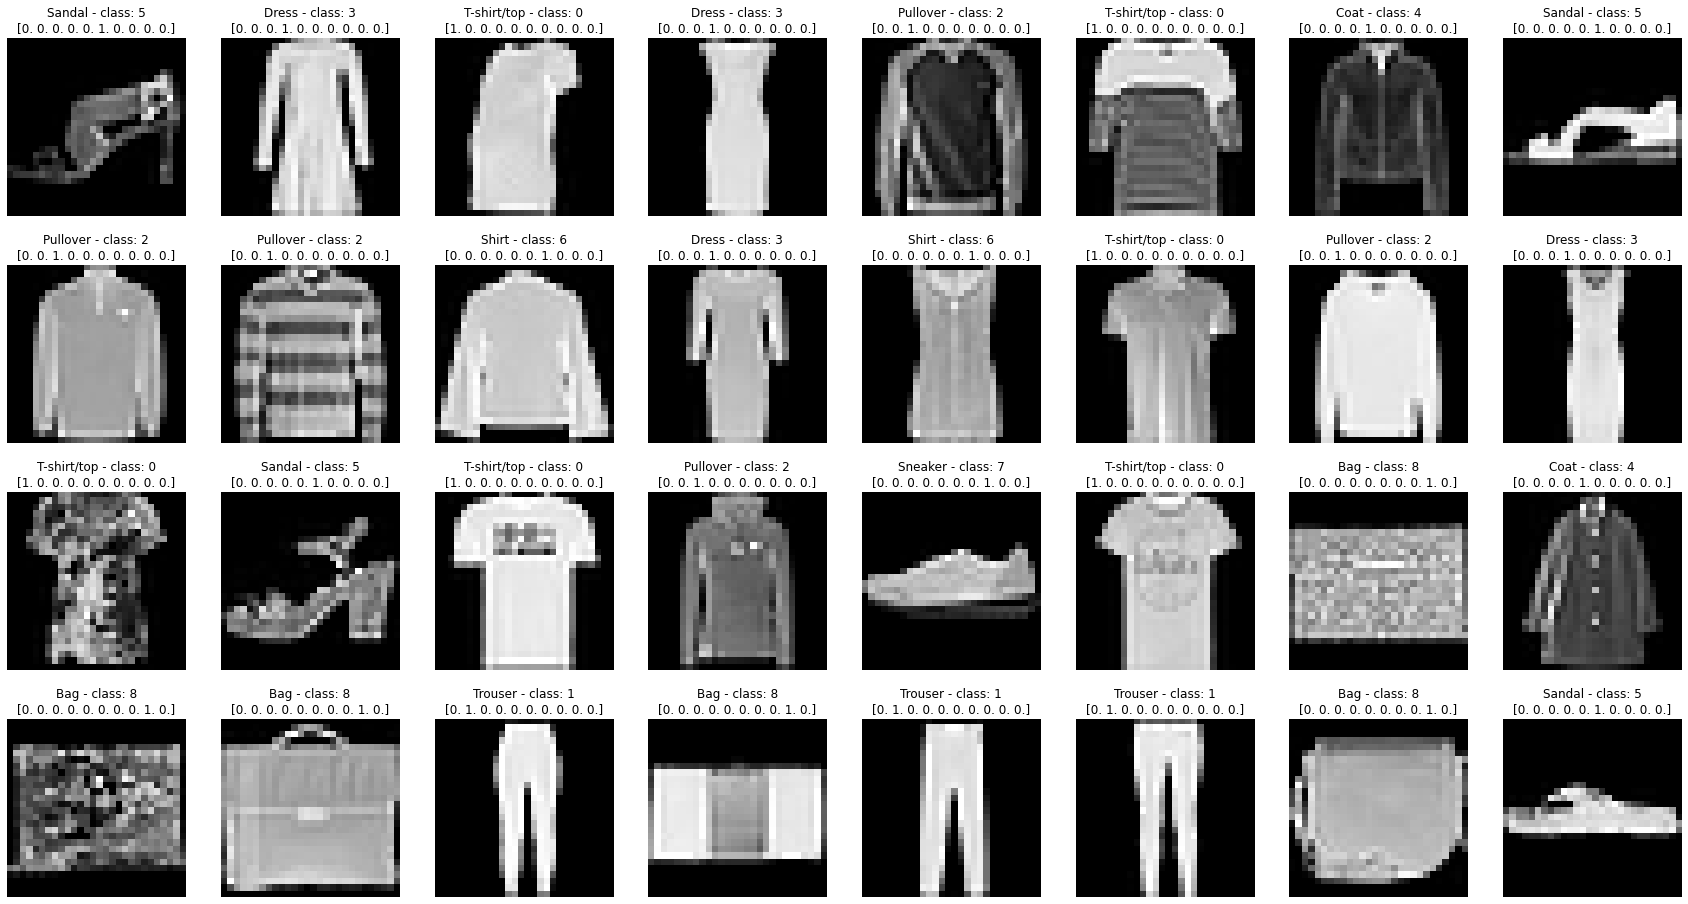

In [6]:
alto = 4
ancho = 8
f, axs = plt.subplots(alto, ancho, figsize=(30,4*alto))
axs = axs.reshape(-1)
for i in range(alto*ancho):
    axs[i].imshow(x_train[i], cmap='gray')
    axs[i].set_title(f'{classes[int(y_train[i])]} - class: {int(y_train[i])}\n{y_train_categorical[i]}')
    axs[i].axis('off')

In [7]:

#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#x_train_scaled = sc.fit_transform(x_train)
#x_valid_scaled = sc.transform(x_valid)
#x_test = sc.transform(x_test)

x_train = x_train / 255
x_valid = x_valid / 255
x_test = x_test / 255

In [8]:
x_train.shape

(54000, 28, 28)

In [9]:
output_size = 10
no_epochs = 100
verbosity = 1
batch_size=256
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=1e-4)
capas_ocultas = 2
neuronas = 800
regularizer = regularizers.l1(1e-6)
initializer=initializers.RandomNormal()
loss_function = 'categorical_crossentropy'

shape = x_train.shape[1:]

# Merge inputs and targets
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_valid), axis=0)
targets = np.concatenate((to_categorical(y_train), to_categorical(y_valid)), axis=0)
#inputs = x_train
#targets = y_train_categorical
num_folds = 3
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 2
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(Flatten(input_shape=shape))
    for i in range(capas_ocultas):
        model.add(Dense(neuronas, activation='relu', kernel_initializer=initializer, kernel_regularizer = regularizer, name=('middle' + str(i+1))))
    model.add(Dense(output_size, name='Salida'))
    model.add(Activation('softmax'))
    model.summary()
    # Compile the model
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

    history = model.fit(inputs[train],
                       targets[train],
                       epochs=20, batch_size=batch_size,
                       verbose=1,
                       validation_data = (x_valid, y_val_categorical)
                      )
    #print(f"model hist is : \n {history.history}")


    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
print(datetime.now().strftime("%d %B %I:%M%p"))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle1 (Dense)             (None, 800)               628000    
                                                                 
 middle2 (Dense)             (None, 800)               640800    
                                                                 
 Salida (Dense)              (None, 10)                8010      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 1,276,810
Trainable params: 1,276,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
157/157 [==========================

In [10]:
loss, acc = model.evaluate(x_valid, y_val_categorical, verbose=0)
print(acc, loss)

0.9125000238418579 0.29116523265838623


In [11]:
# Calculo probabilidades de cada clase para cada observación
test_prediction = model.predict(x_test)
print(test_prediction.shape)

313/313 [==============================] - 2s 5ms/step
(10000, 10)


In [12]:
# Calculo clase
test_labels = np.argmax(test_prediction, axis = 1)
print(test_labels)

[3 2 7 ... 2 0 7]


# Armo CSV para submitear

In [13]:
import pandas
df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission.csv", sep=',',index=True,  index_label='Id')